In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from math import sqrt

import DataAid
import Neros

In [2]:
# Collect the data from each of the folders
sparcGalaxies = DataAid.GetGalaxyData("data/Sparc/Rotmod_LTG/")
xueSofueGalaxies = DataAid.GetGalaxyData("data/XueSofue/")

In [3]:
# Get the galaxies we want from each source
NGC5371 = np.array(sparcGalaxies['NGC5371_rotmod'])
MWXueSofue = np.array(xueSofueGalaxies['MW_lum'])

In [4]:
NGC5371_rad = NGC5371[:,0]
NGC5371_Vobs = NGC5371[:,1]
NGC5371_gas = NGC5371[:,3]
NGC5371_disk = NGC5371[:,4]
NGC5371_bulge = NGC5371[:,5]
NGC5371_VlumSquared = Neros.VlumSquared(NGC5371_gas, NGC5371_disk, NGC5371_bulge)
NGC5371_Vlum = np.sqrt(NGC5371_VlumSquared)

MW_rad = MWXueSofue[:,0]
MW_Vlum = MWXueSofue[:,1]
# Interpolation function
MW_Vlum_interp_func = interp1d(MW_rad, MW_Vlum, kind='cubic')

In [5]:
NGC5371_Vlum

array([240.9       , 232.56      , 235.54      , 243.76      ,
       245.32      , 253.        , 281.80424766, 301.0640108 ,
       297.9484353 , 297.91609356, 290.69624731, 273.32879724,
       255.76223588, 241.1307498 , 229.42754848, 215.73120892,
       205.04713848, 196.15502874, 188.6676745 ])

In [6]:
Vlcm = Neros.Vlcm(NGC5371_rad, MW_Vlum_interp_func(NGC5371_rad), NGC5371_Vlum)
print("Vlcm: ")
print(Vlcm)

[CALCULATING PHI FOR MW]
---Integrating----
0.0  ->  1.45
With constant v^2:  38633.981839538865
Value:  1.7890470064247746e-05
---Integrating----
1.45  ->  2.88
With constant v^2:  30614.013348577384
Value:  2.3342393898410104e-07
---Integrating----
2.88  ->  4.33
With constant v^2:  27771.512252692602
Value:  1.258287870610555e-07
---Integrating----
4.33  ->  5.78
With constant v^2:  26493.52475738531
Value:  8.50254160407255e-08
---Integrating----
5.78  ->  7.22
With constant v^2:  24836.44280524592
Value:  6.138775833093865e-08
---Integrating----
7.22  ->  8.66
With constant v^2:  23346.153382938326
Value:  4.717473418769474e-08
---Integrating----
8.66  ->  11.55
With constant v^2:  20563.04143908668
Value:  6.579504148128987e-08
---Integrating----
11.55  ->  14.48
With constant v^2:  17968.077128509794
Value:  4.513639869841298e-08
---Integrating----
14.48  ->  17.28
With constant v^2:  15837.744309395035
Value:  3.1109091537517497e-08
---Integrating----
17.28  ->  20.2
With const

/Users/Zac/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [7]:
NGC5371_rad

array([ 1.45,  2.88,  4.33,  5.78,  7.22,  8.66, 11.55, 14.48, 17.28,
       20.2 , 23.12, 26.04, 28.84, 31.76, 34.68, 37.48, 40.4 , 43.32,
       46.24])

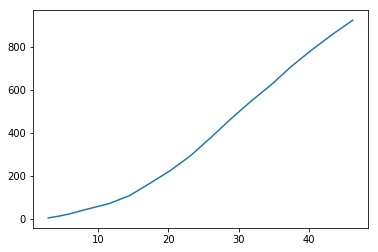

In [8]:
plt.plot(NGC5371_rad, Vlcm)
plt.show()